# Imports and general functions

In [4]:
import scipy.special as special
import scipy.linalg as linalg
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
from time import time
import qutip as qt
import scipy.fft as fft
import scipy as sc

In [5]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [6]:
h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.602e-19
phi0 = h/(2*e)
phi0bar = phi0/(2*np.pi)
gap = 0.00017*e # from Kittel
Zq = phi0bar/(2*e)
kb = 1.38e-23

In [7]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def matel(x, i, j):
    n = min(i, j)
    m = max(i, j)
    factor = (-0.5)**((m-n)/2.) \
            *1./np.sqrt(special.poch(n+1,m-n)) \
            *x**(m-n) \
            *np.exp(-0.25*x**2) \
            *special.eval_genlaguerre(n, m-n, 0.5*x**2)
    return factor

def cosx(p, i, j):
    if (i-j)%2 == 0:
        return matel(np.sqrt(2)*p, i, j)
    else:
        return 0

def sinx(p, i, j):
    if (i-j)%2 == 1:
        comp = -1j*matel(np.sqrt(2)*p, i, j)
        if abs(np.imag(comp)) > 1e-10:
            raise ValueError("Matrix element is complex")
        else:
            return np.real(comp)
    else:
        return 0

def progress(pos, tot):
    if pos % int(tot/10) == 0:
        print('.', end='')

def cap(EC):
    EC = EC*1e9*h
    return e**2/(2*EC)

def ind(EL):
    EL = EL*1e9*h
    return phi0bar**2/EL

def enc(C):
    C = C*1e9*h
    return e**2/(2*C)

def enl(L):
    L = L*1e9*h
    return phi0bar**2/L

def phizpf(L, C):
    EL = enl(L)
    EC = enc(C)
    return (2*EC/EL)**0.25

def Nzpf(L, C):
    EL = enl(L)
    EC = enc(C)
    return 0.5*(0.5*EL/EC)**0.25

## Building the Hamiltonian

In [8]:
def first_n_states_sparse(ham,n_cutoff):
    ev = np.zeros(n_cutoff,dtype=np.cfloat)
    evec = np.zeros(((2*dim[0]+1)*dim[2]*dim[1], n_cutoff),dtype=np.cfloat)
    ev, evec = sparse.linalg.eigs(ham, k=n_cutoff, which='SR', return_eigenvectors=True)
    return ev, evec

In [9]:
def matrices_f_sparse(dim, params):
    FOCK = dim[2]
    EC, EL = params[0], params[2]
    ECf, ELf = 0.5*EC, 2*EL
    zpf = phizpf(ind(ELf), cap(ECf))
    
    COS = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    SIN = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    
    for i in range(FOCK):
        for j in range(FOCK):
            COS[i,j] += cosx(zpf, i, j)
            SIN[i,j] += sinx(zpf, i, j)
    COSsparse = sparse.dia_array(COS)
    SINsparse = sparse.dia_array(SIN)

    return COSsparse, SINsparse

def matrices_r_sparse(dim, params):
    fock = dim[1]
    EC, EL = params[0], params[2]
    ECf, ELf = 0.5*EC, 2*EL
    zpf = phizpf(ind(ELf), cap(ECf))
    
    COS = np.zeros((fock,fock), dtype=np.cfloat)
    SIN = np.zeros((fock,fock), dtype=np.cfloat)
    
    for i in range(fock):
        for j in range(fock):
            COS[i,j] += cosx(zpf, i, j)
            SIN[i,j] += sinx(zpf, i, j)
    COSsparse = sparse.dia_array(COS)
    SINsparse = sparse.dia_array(SIN)

    return COSsparse, SINsparse

def _Hamiltonian2_sparse(dim, ng, params, COSr_sparse, SINr_sparse, COSf_sparse, SINf_sparse):
    DIM, fock, FOCK = dim
    EC, EJ, EL, y, dC, dJ, dL = params
    Nc = 2*DIM+1

    ECc, ECr, ECf = y*EC, 0.5*EC, 0.5*EC
    ELr, ELf = 2*EL, 2*EL   
    
    Qc = np.zeros((Nc,Nc), dtype=np.cfloat)
    COSc = np.zeros((Nc,Nc), dtype=np.cfloat)
    SINc = np.zeros((Nc,Nc), dtype=np.cfloat)
    Hr = np.zeros((fock,fock), dtype=np.cfloat)
    Qr = np.zeros((fock,fock), dtype=np.cfloat)
    Fr = np.zeros((fock,fock), dtype=np.cfloat)
    Hf = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    Qf = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    Ff = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    
    for i in range(Nc):
        I = i-DIM
        Qc[i,i] += I-ng
        for j in range(Nc):
            if i == j-1:
                COSc[i,j] += 0.5
                SINc[i,j] += +0.5*1j
            elif i == j+1:
                COSc[i,j] += 0.5
                SINc[i,j] += -0.5*1j
    for i in range(fock):
        Hr[i,i] += np.sqrt(8*ECr*ELr)*i
        for j in range(fock):
            if i == j-1:
                Qr[i,j] -= 1j*0.5*(ELr/(2*ECr))**0.25*np.sqrt(j)
                Fr[i,j] += (2*ECr/ELr)**0.25*np.sqrt(j)
            elif i == j+1:
                Qr[i,j] += 1j*0.5*(ELr/(2*ECr))**0.25*np.sqrt(i)
                Fr[i,j] += (2*ECr/ELr)**0.25*np.sqrt(i)
    for i in range(FOCK):
        Hf[i,i] += np.sqrt(8*ECf*ELf)*i
        for j in range(FOCK):
            if i == j-1:
                Qf[i,j] -= 1j*0.5*(ELf/(2*ECf))**0.25*np.sqrt(j)
                Ff[i,j] += (2*ECf/ELf)**0.25*np.sqrt(j)
            elif i == j+1:
                Qf[i,j] += 1j*0.5*(ELf/(2*ECf))**0.25*np.sqrt(i)
                Ff[i,j] += (2*ECf/ELf)**0.25*np.sqrt(i)
    
    Qc_sparse = sparse.dia_array(Qc)
    Qr_sparse = sparse.dia_array(Qr)
    Qf_sparse = sparse.dia_array(Qf)
    Fr_sparse = sparse.dia_array(Fr)
    Ff_sparse = sparse.dia_array(Ff)
    Hr_sparse = sparse.dia_array(Hr)
    Hf_sparse = sparse.dia_array(Hf)
    COSc_sparse = sparse.dia_array(COSc)
    SINc_sparse = sparse.dia_array(SINc)
    
    #diagonal terms
    H0 = 4 * ECc * sparse.kron(Qc_sparse@Qc_sparse, sparse.eye(fock*FOCK)) \
        + sparse.kron(sparse.eye(Nc), sparse.kron(Hr_sparse, sparse.eye(FOCK))) \
        + sparse.kron(sparse.eye(Nc*fock), Hf_sparse) \
        + 4 * ECc * sparse.kron(sparse.eye(Nc), sparse.kron(Qr_sparse@Qr_sparse, sparse.eye(FOCK)))
    #capacitive coupling terms
    H1 = + 8 * ECc * sparse.kron(Qc_sparse, sparse.kron(Qr_sparse, sparse.eye(FOCK))) \
            - 2* dC * sparse.kron(sparse.eye(Nc), sparse.kron(Qr_sparse, Qf_sparse))
    #inductive coupling terms
    H2 = + dL * sparse.kron(sparse.eye(Nc), sparse.kron(Fr_sparse, Ff_sparse))
    #junction terms that go with cos(phiext/2)
    H3 = - 2 * EJ * (sparse.kron(COSc_sparse, sparse.kron(COSr_sparse, COSf_sparse)) + sparse.kron(SINc_sparse, sparse.kron(SINr_sparse, COSf_sparse))) \
             + dJ *( sparse.kron(SINc_sparse, sparse.kron(COSr_sparse, SINf_sparse)) - sparse.kron(COSc_sparse, sparse.kron(SINr_sparse, SINf_sparse)))
    #junction terms that go with sin(phiext/2)
    H4 = + 2 * EJ * (sparse.kron(COSc_sparse, sparse.kron(COSr_sparse, SINf_sparse)) + sparse.kron(SINc_sparse, sparse.kron(SINr_sparse, SINf_sparse))) \
                    + dJ *( sparse.kron(SINc_sparse, sparse.kron(COSr_sparse, COSf_sparse)) - sparse.kron(COSc_sparse, sparse.kron(SINr_sparse, COSf_sparse)))

    return H0+H1, H3, H4


def Hamiltonian_sparse(H, phiext):
    return H[0] + np.cos(phiext/2)*H[1] + np.sin(phiext/2)*H[2]

## One-mode model

In [10]:
def hamiltonian_cos2phi(Ec, Ej2, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) + 0.5 * Ej2 * (np.diag(-np.ones(2*N-1),2) + 
                                                               np.diag(-np.ones(2*N-1), -2))
    return qt.Qobj(m)
    
def cos2phi_charge_dispersion(EC,EJ,dim,nng,nlevels):
    ng_tab = np.linspace(0,2,nng)
    points = np.zeros((nlevels,nng))
    for i,ng in enumerate(ng_tab):
        H = hamiltonian_cos2phi(EC,EJ,dim,ng)
        evals, ekets = H.eigenstates()
        points[:,i] = evals[:nlevels]
    return ng_tab,points - np.average(points[0]+points[1])/2

def cos2phi_levels(EC,EJ,dim,ng,nlevels):
    points = np.zeros(nlevels)
    H = hamiltonian_cos2phi(EC,EJ,dim,ng)
    evals, ekets = H.eigenstates()
    points = evals[:nlevels]
    return points - (points[0]+points[1])/2

In [11]:
def hamiltonian_cosphi_cos2phi(Ec, EJ1, Ej2, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) + 0.5 * Ej2 * (np.diag(np.ones(2*N-1),2) + 
                                                               np.diag(np.ones(2*N-1), -2)) + 0.5 * EJ1 * (np.diag(-np.ones(2*N),1) + np.diag(-np.ones(2*N), -1))
    return qt.Qobj(m)

def hamiltonian_sinphi_cos2phi(Ec, EJ1, Ej2, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) - 0.5 * Ej2 * (np.diag(np.ones(2*N-1),2) + 
                                                               np.diag(np.ones(2*N-1), -2)) + 0.5 * EJ1 * (np.diag(-np.ones(2*N),1) - np.diag(-np.ones(2*N), -1))
    return qt.Qobj(m)
def cosphi_cos2phi_charge_dispersion(EC,EJ1,EJ2,dim,nng,nlevels):
    ng_tab = np.linspace(0,2,nng)
    points = np.zeros((nlevels,nng))
    for i,ng in enumerate(ng_tab):
        H = hamiltonian_cosphi_cos2phi(EC,EJ1,EJ2,dim,ng)
        evals, ekets = H.eigenstates()
        points[:,i] = evals[:nlevels]
    return ng_tab,points - np.average(points[0]+points[1])/2

def cosphi_cos2phi_levels(EC,EJ1,EJ2,dim,ng,nlevels):
    points = np.zeros(nlevels)
    H = hamiltonian_cosphi_cos2phi(EC,EJ1,EJ2,dim,ng)
    evals, ekets = H.eigenstates()
    points = evals[:nlevels]
    return points - (points[0]+points[1])/2
    
def N_matelt_1D(EC,EJ1,EJ2,dim,ng,nlevels):
    H = hamiltonian_cosphi_cos2phi(EC, EJ1, EJ2, dim, ng)
    evals, ekets = H.eigenstates()
    N = qt.Qobj(np.diag(np.arange(-dim,dim+1)))
    return (ekets[1].dag()*N*ekets[0])[0][0][0], ekets[0],ekets[1]

def N_matelt_1D_sin(EC,EJ1,EJ2,dim,ng,nlevels):
    H = hamiltonian_sinphi_cos2phi(EC, EJ1, EJ2, dim, ng)
    evals, ekets = H.eigenstates()
    N = qt.Qobj(np.diag(np.arange(-dim,dim+1)))
    return (ekets[1].dag()*N*ekets[0])[0][0][0], ekets[0],ekets[1]


## Born-Oppenheimer functions

In [12]:
def matrices(dim, params):
    FOCK = dim
    EC, EL = params[0], params[2]
    ECf, ELf = EC, EL
    zpf = phizpf(ind(ELf), cap(ECf))
    
    COS = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    SIN = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    
    for i in range(FOCK):
        for j in range(FOCK):
            COS[i,j] += cosx(zpf, i, j)
            SIN[i,j] += sinx(zpf, i, j)
            
    return COS, SIN

def _fluxoHam(dim, params, COS, SIN):
    EC, EJ, EL = params

    
    Hf = np.zeros((dim,dim), dtype=np.cfloat)
    Qf = np.zeros((dim,dim), dtype=np.cfloat)
    Ff = np.zeros((dim,dim), dtype=np.cfloat)
    
    for i in range(dim):
        Hf[i,i] += np.sqrt(8*EC*EL)*i
        for j in range(dim):
            if i == j-1:
                Qf[i,j] -= 1j*0.5*(EL/(2*EC))**0.25*np.sqrt(j)
                Ff[i,j] += (2*EC/EL)**0.25*np.sqrt(j)
            elif i == j+1:
                Qf[i,j] += 1j*0.5*(EL/(2*EC))**0.25*np.sqrt(i)
                Ff[i,j] += (2*EC/EL)**0.25*np.sqrt(i)
                
    
    #diagonal terms
    H0 = Hf
    #junction terms that go with cos(phiext)
    H3 = - EJ * COS
    #junction terms that go with sin(phiext)
    H4 = + EJ * SIN
    
    return H0, H3, H4


def Hamiltonian(H, phiext):
    return H[0] + np.cos(phiext)*H[1] + np.sin(phiext)*H[2]


def flux_dispersion(H,nflux_points):
    ev = np.zeros((nflux_points,2))
    flux_tab = np.linspace(0,2*np.pi,nflux_points+1)
    for k in range(nflux_points):
        ham = Hamiltonian(H,flux_tab[k])
        ev[k] = linalg.eigvalsh(ham, subset_by_index=[0,1])
    return flux_tab[:-1],ev

def flux_dispersion_evecs(H,nflux_points):
    ev = np.zeros((nflux_points,2))
    evec = np.zeros((nflux_points,len(H[0]),2),dtype='complex128')
    flux_tab = np.linspace(-np.pi,np.pi,nflux_points+1)
    for k in range(nflux_points):
        ham = Hamiltonian(H,flux_tab[k])
        ev[k], evec[k] = linalg.eigh(ham, subset_by_index=[0,1])
    return flux_tab[:-1],ev, evec

In [13]:
def gap(ev):
    return np.min(ev[:,1]-ev[:,0])

def effective_potential(ev, phiext):
    nflux_points = len(ev)
    index = int(nflux_points*phiext/2/np.pi)
    pot = np.zeros(nflux_points)
    for k in range(nflux_points):
        pot[k] = ev[k,0] + ev[(k+index)%nflux_points,0]
    return pot    

def effective_potential_sym(ev, phiext):
    nflux_points = len(ev)
    index = int(nflux_points*phiext/4/np.pi)
    pot = np.zeros(nflux_points)
    for k in range(nflux_points):
        pot[k] = ev[(k-index)%nflux_points,0] + ev[(k+index)%nflux_points,0]
    return pot    

In [14]:
def potential_matrix(pot,dim):
    fourier = fft.fft(pot)/len(pot)
    mat = np.zeros((2*dim+1,2*dim+1),dtype='complex128')
    for k in range(1,dim):
        mat += fourier[k]*np.diag(np.ones(2*dim-k+1),k) +  np.conj(fourier[k])*np.diag(np.ones(2*dim-k+1), -k)
    return mat

In [15]:
def one_mode_Ham(dim,mat,EC,ng):
    return np.diag(4 * EC * (np.arange(-dim,dim+1)-ng)**2) + mat
def one_mode_Ham_asym(dim,mat,EC,ng,EJ1):
    return np.diag(4 * EC * (np.arange(-dim,dim+1)-ng)**2) + mat - 0.5*EJ1 * (np.diag(-np.ones(2*dim),1) + 
                                                               np.diag(-np.ones(2*dim), -1))
def one_mode_levels(dim,Ham,n_cutoff):
    ev = np.zeros(n_cutoff,dtype=np.cfloat)
    evec = np.zeros((2*dim[0]+1, n_cutoff),dtype=np.cfloat)
    ev, evec = linalg.eigh(Ham, subset_by_index=[0,n_cutoff-1])
    return ev, evec

In [16]:
def hamiltonian_cpb(Ec, Ej, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N,N+1)-ng)**2) + 0.5 * Ej * (np.diag(-np.ones(2*N),1) + 
                                                               np.diag(-np.ones(2*N), -1))
    return qt.Qobj(m)
    
def CPB_charge_dispersion(EC,EJ,dim,nng):
    ng_tab = np.linspace(0,2,nng)
    points = np.zeros(nng)
    for i,ng in enumerate(ng_tab):
        H = hamiltonian_cpb(EC,EJ,dim,ng)
        evals, ekets = H.eigenstates()
        points[i] = evals[0]
    return ng_tab,points - np.average(points)

In [17]:
def Born_Op_diag(EC,EJ,EL,y,dim,ncutoff,nfluxpoints,phiext,ng):
    params = [EC,EJ,EL]
    mats= matrices(dim[1],params)
    H_fluxo = _fluxoHam(dim[1],params,*mats)
    flux_tab, eivals = flux_dispersion(H_fluxo,nfluxpoints)
    pot = effective_potential(eivals, phiext)
    mat = potential_matrix(pot,dim[0])
    Ham = one_mode_Ham(dim[0],mat,y*EC,ng)
    gap_BO = gap(eivals)
    return *one_mode_levels(dim,Ham,ncutoff) ,gap_BO

In [18]:
def Born_Op_diag_asym(EC,EJ,EL,EJ1,y,dim,ncutoff,nfluxpoints,phiext,ng):
    params = [EC,EJ,EL]
    mats= matrices(dim[1],params)
    H_fluxo = _fluxoHam(dim[1],params,*mats)
    flux_tab, eivals = flux_dispersion(H_fluxo,nfluxpoints)
    pot = effective_potential(eivals, phiext)
    mat = potential_matrix(pot,dim[0])
    Ham = one_mode_Ham_asym(dim[0],mat,y*EC,ng,EJ1)
    gap_BO = gap(eivals)
    return *one_mode_levels(dim,Ham,ncutoff) ,gap_BO

In [19]:
def Born_Op_diag_with_evecs(EC,EJ,EL,y,dim,ncutoff,nfluxpoints,phiext,ng):
    params = [EC,EJ,EL]
    mats = matrices(dim[1],params)
    H_fluxo = _fluxoHam(dim[1],params,*mats)
    flux_tab, eivals, eivecs = flux_dispersion_evecs(H_fluxo,nfluxpoints)
    pot = effective_potential(eivals, phiext)
    mat = potential_matrix(pot,dim[0])
    Ham = one_mode_Ham(dim[0],mat,y*EC,ng)
    gap_BO = gap(eivals)
    return *one_mode_levels(dim,Ham,ncutoff), gap_BO, eivecs[:,:,0]

In [20]:
def Born_Op_diag_with_evecs_sym(EC,EJ,EL,y,dim,ncutoff,nfluxpoints,phiext,ng):
    params = [EC,EJ,EL]
    mats = matrices(dim[1],params)
    H_fluxo = _fluxoHam(dim[1],params,*mats)
    flux_tab, eivals, eivecs = flux_dispersion_evecs(H_fluxo,nfluxpoints)
    pot = effective_potential_sym(eivals, phiext)
    mat = potential_matrix(pot,dim[0])
    Ham = one_mode_Ham(dim[0],mat,y*EC,ng)
    gap_BO = gap(eivals)
    return *one_mode_levels(dim,Ham,ncutoff), gap_BO, eivecs[:,:,0]

In [21]:
def harmonics(EC,EJ,EL,dim,nfluxpoints,phiext):
    params = [EC,EJ,EL]
    mats= matrices(dim[1],params)
    H_fluxo = _fluxoHam(dim[1],params,*mats)
    flux_tab, eivals = flux_dispersion(H_fluxo,nfluxpoints)
    pot = effective_potential(eivals, phiext)
    fourier = fft.fft(pot)/len(pot)
    return np.real(fourier[:dim[0]])

## Operators

In [22]:
def Nsigma_op(dim,params):  #eta operator
    DIM, fock, FOCK = dim
    Nc = 2*DIM+1
    EC, EJ, EL, y, dC, dJ, dL = params
    ECr, ELr = 0.5*EC, 2*EL
    Qr = np.zeros((fock,fock), dtype=np.cfloat)
    for i in range(fock):
        for j in range(fock):
            if i == j-1:
                Qr[i,j] -= 1j*0.5*(ELr/(2*ECr))**0.25*np.sqrt(j)
            elif i == j+1:
                Qr[i,j] += 1j*0.5*(ELr/(2*ECr))**0.25*np.sqrt(i)
    return np.kron(np.eye(Nc),np.kron(Qr, np.eye(FOCK)))

def Ndelta_op(dim,params):
    DIM, fock, FOCK = dim
    Nc = 2*DIM+1
    EC, EJ, EL, y, dC, dJ, dL = params
    ECf, ELf = 0.5*EC, 2*EL
    Qf = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    for i in range(FOCK):
        for j in range(FOCK):
            if i == j-1:
                Qf[i,j] -= 1j*0.5*(ELf/(2*ECf))**0.25*np.sqrt(j)
            elif i == j+1:
                Qf[i,j] += 1j*0.5*(ELf/(2*ECf))**0.25*np.sqrt(i)
    return np.kron(np.eye(Nc),np.kron(np.eye(fock), Qf))

def N_op(dim,params,ng): 
    DIM, fock, FOCK = dim
    Nc = 2*DIM+1
    EC, EJ, EL, y, dC, dJ, dL = params
    Qc = np.zeros((Nc,Nc), dtype=np.cfloat)  
    for i in range(Nc):
        I = i-DIM
        Qc[i,i] += I-ng
    return np.kron(Qc,np.kron(np.eye(fock),np.eye(FOCK)))

def phidelta_op(dim,params): #phi operator
    DIM, fock, FOCK = dim
    Nc = 2*DIM+1
    EC, EJ, EL, y, dC, dJ, dL = params
    ECf, ELf = 0.5*EC, 2*EL
    Ff = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    for i in range(FOCK):
        for j in range(FOCK):
            if i == j-1:
                Ff[i,j] += (2*ECf/ELf)**0.25*np.sqrt(j)
            elif i == j+1:
                Ff[i,j] += (2*ECf/ELf)**0.25*np.sqrt(i)
    return np.kron(np.eye(Nc),np.kron(np.eye(fock),Ff))


def phisigma_op(dim,params): 
    DIM, fock, FOCK = dim
    Nc = 2*DIM+1
    EC, EJ, EL, y, dC, dJ, dL = params
    ECr, ELr = 0.5*EC, 2*EL
    Fr = np.zeros((fock,fock), dtype=np.cfloat)
    for i in range(fock):
        for j in range(fock):
            if i == j-1:
                Fr[i,j] += (2*ECr/ELr)**0.25*np.sqrt(j)
            elif i == j+1:
                Fr[i,j] += (2*ECr/ELr)**0.25*np.sqrt(i)
    return np.kron(np.kron(np.eye(Nc),Fr),np.eye(FOCK))

In [23]:
def off_diagonal(states,op,i,j):
    psi0 = states[:,i]
    psi1 = states[:,j]
    return np.vdot(psi1,np.dot(op,psi0))

## Wavefunctions

In [24]:
def fock_wf(n,x,EC,EL):
    zpf = zpf = phizpf(ind(EL), cap(EC))
    Hn = special.hermite(n)
    return 1/np.sqrt(2**n*special.factorial(n)*zpf)*1/(2*np.pi)**0.25*np.exp(-(0.5*x/zpf)**2)*Hn(1/np.sqrt(2)*x/zpf)

def phidelta_varphi_wf(state,dim,params,npoints,phi_lim):
    EC, EJ, EL, y, dC, dJ, dL = params
    ECc, ECr, ECf = y*EC, 0.5*EC, 0.5*EC
    ELr, ELf = EL, EL
    state = np.reshape(state,(2*dim[0]+1,dim[1],dim[2]))
    phi_array = np.linspace(-phi_lim,phi_lim,npoints[0])
    varphi_array = np.linspace(-np.pi/2,3*np.pi/2,npoints[1])
    phi_grid, varphi_grid = np.meshgrid(phi_array,varphi_array)
    res = np.transpose(np.zeros(npoints,dtype='complex128'))
    for p in range(dim[1]):
        for q in range(dim[2]):
            for N in range(2*dim[0]+1):
                res += state[N,p,q]*np.exp(-1j*(N-dim[0])*varphi_grid)*fock_wf(p,0,ECr,ELr)*fock_wf(q,phi_grid,ECf,ELf)
    res = normalize(res)
    return res, phi_grid, varphi_grid

def phidelta_varphi_wf_displaced(state,dim,params,npoints,phi_lim, phisigma_val):
    EC, EJ, EL, y, dC, dJ, dL = params
    ECc, ECr, ECf = y*EC, 0.5*EC, 0.5*EC
    ELr, ELf = EL, EL
    state = np.reshape(state,(2*dim[0]+1,dim[1],dim[2]))
    phi_array = np.linspace(-phi_lim,phi_lim,npoints[0])
    varphi_array = np.linspace(-np.pi/2,3*np.pi/2,npoints[1])
    phi_grid, varphi_grid = np.meshgrid(phi_array,varphi_array)
    res = np.transpose(np.zeros(npoints,dtype='complex128'))
    for p in range(dim[1]):
        for q in range(dim[2]):
            for N in range(2*dim[0]+1):
                res += state[N,p,q]*np.exp(-1j*(N-dim[0])*varphi_grid)*fock_wf(p,phisigma_val,ECr,ELr)*fock_wf(q,phi_grid,ECf,ELf)
    res = normalize(res)
    return res, phi_grid, varphi_grid
def phisigma_varphi_wf(state,dim,params,npoints,theta_lim):
    EC, EJ, EL, y, dC, dJ, dL = params
    ECc, ECr, ECf = y*EC, 0.5*EC, 0.5*EC
    ELr, ELf = EL, EL
    state = np.reshape(state,(2*dim[0]+1,dim[1],dim[2]))
    theta_array = np.linspace(-theta_lim,theta_lim,npoints[0])
    varphi_array = np.linspace(-np.pi/2,3*np.pi/2,npoints[1])
    theta_grid, varphi_grid = np.meshgrid(theta_array,varphi_array)
    res = np.transpose(np.zeros(npoints,dtype='complex128'))
    for p in range(dim[1]):
        for q in range(dim[2]):
            for N in range(2*dim[0]+1):
                res += state[N,p,q]*np.exp(-1j*(N-dim[0])*varphi_grid)*fock_wf(p,theta_grid,ECr,ELr)*fock_wf(q,0,ECf,ELf)
    res = normalize(res)
    return res, theta_grid, varphi_grid
    
def threed_wf(state,dim,params,npoints,phi_lim,theta_lim):
    EC, EJ, EL, y, dC, dJ, dL = params
    ECr, ECf = y*EC, 2*EC
    ELr, ELf = 2*EL, EL/2
    state = np.reshape(state,(2*dim[0]+1,dim[1],dim[2]))
    phi_array = np.linspace(-phi_lim,phi_lim,npoints[2])
    varphi_array = np.linspace(-2*np.pi,2*np.pi,npoints[0])
    theta_array = np.linspace(-theta_lim,theta_lim,npoints[1])
    phi_grid, varphi_grid, theta_grid = np.meshgrid(phi_array,varphi_array,theta_array)
    res = np.zeros(npoints,dtype='complex128')
    for p in range(dim[1]):
        for q in range(dim[2]):
            for N in range(2*dim[0]+1):
                res += state[N,p,q]*np.exp(-1j*(N-dim[0])*varphi_grid)*fock_wf(p,theta_grid,ECr,ELr)*fock_wf(q,phi_grid,ECf,ELf)
    res= normalize(res)
    return res, phi_grid, varphi_grid, theta_grid

def phidelta_N_wf(state,dim,params,npoints,phi_lim):
    EC, EJ, EL, y, dC, dJ, dL = params
    ECr, ECf = y*EC, 2*EC
    ELr, ELf = 2*EL, EL/2
    state = np.reshape(state,(2*dim[0]+1,dim[1],dim[2]))
    phi_array = np.linspace(-phi_lim,phi_lim,npoints)
    N_array = np.arange(-dim[0],dim[0]+1)
    phi_grid, N_grid = np.meshgrid(phi_array,N_array)
    res = np.transpose(np.zeros((npoints,2*dim[0]+1),dtype='complex128'))
    for p in range(dim[1]):
        for q in range(dim[2]):
            fourier, dummy = np.meshgrid(np.array([state[int(n)+dim[0],p,q] for n in N_array]),np.ones(npoints))
            res += np.transpose(fourier)*fock_wf(p,0,ECr,ELr)*fock_wf(q,phi_grid,ECf,ELf)
    res = normalize(res)
    return res, phi_grid, N_grid

def Nsigma_N_wf(state,dim,params,npoints,P_lim,phi_value):
    EC, EJ, EL, y, dC, dJ, dL = params
    ECr, ECf = y*EC, 2*EC
    ELr, ELf = 2*EL, EL/2
    state = np.reshape(state,(2*dim[0]+1,dim[1],dim[2]))
    P_array = np.linspace(-P_lim,P_lim,npoints)
    N_array = np.arange(-dim[0],dim[0]+1)
    P_grid, N_grid = np.meshgrid(P_array,N_array)
    res = np.transpose(np.zeros((npoints,2*dim[0]+1),dtype='complex128'))
    for p in range(dim[1]):
        for q in range(dim[2]):
            fourier, dummy = np.meshgrid(np.array([state[int(n)+dim[0],p,q] for n in N_array]),np.ones(npoints))
            res += np.transpose(fourier)*fock_wf(p,P_grid,ELr,ECr)*fock_wf(q,phi_value,ECf,ELf)
    res = normalize(res)
    return res, P_grid, N_grid

def Ndelta_N_wf(state,dim,params,npoints,M_lim,theta_value):
    EC, EJ, EL, y, dC, dJ, dL = params
    ECr, ECf = y*EC, 2*EC
    ELr, ELf = 2*EL, EL/2
    state = np.reshape(state,(2*dim[0]+1,dim[1],dim[2]))
    M_array = np.linspace(-M_lim,M_lim,npoints)
    N_array = np.arange(-dim[0],dim[0]+1)
    M_grid, N_grid = np.meshgrid(M_array,N_array)
    res = np.transpose(np.zeros((npoints,2*dim[0]+1),dtype='complex128'))
    for p in range(dim[1]):
        for q in range(dim[2]):
            fourier, dummy = np.meshgrid(np.array([state[int(n)+dim[0],p,q] for n in N_array]),np.ones(npoints))
            res += np.transpose(fourier)*fock_wf(p,theta_value,ECr,ELr)*fock_wf(q,M_grid,ELf,ECf)
    res = normalize(res)
    return res, M_grid, N_grid

In [25]:
def BO_wf_sym(level,wf_slow, wf_fast, dim, ng, phiext):
    nflux_points = len(wf_fast)
    flux_tab = np.linspace(-np.pi,np.pi,nflux_points+1)[:-1]
    index = int(nflux_points*phiext/4/np.pi)
    psi = np.zeros((nflux_points,dim[1],dim[1]),dtype='complex128')
    for k in range(2*dim[0]+1):
        for j,phi in enumerate(flux_tab):
            psi[j] += wf_slow[k,level]*np.exp(1j*(k-dim[0])*phi)*np.outer(normalize(wf_fast[(j+index)%nflux_points]),normalize(wf_fast[(j-index)%nflux_points]))
    return psi

In [26]:
def phidelta_varphi_wf_BO(state,dim,params,npoints,phi_lim):
    EC, EJ, EL, y, dC, dJ, dL = params
    nflux_points = len(state)
    phi_array = np.linspace(-phi_lim,phi_lim,npoints)
    varphi_array = np.linspace(-np.pi,np.pi,nflux_points+1)[:-1]
    phi_grid, varphi_grid = np.meshgrid(phi_array,varphi_array)
    res = np.zeros((nflux_points,npoints),dtype='complex128')
    for p in range(dim[1]):
        for q in range(dim[1]):
            res += np.outer(state[:,p,q],fock_wf(p,phi_array,EC,EL)*fock_wf(q,-phi_array,EC,EL))
    res = normalize(res)
    return res, phi_grid, varphi_grid

In [27]:
def phisigma_varphi_wf_BO(state,dim,params,npoints,phi_lim,phi_delta):
    EC, EJ, EL, y, dC, dJ, dL = params
    nflux_points = len(state)
    phi_array = np.linspace(-phi_lim,phi_lim,npoints)
    varphi_array = np.linspace(-np.pi,np.pi,nflux_points+1)[:-1]
    phi_grid, varphi_grid = np.meshgrid(phi_array,varphi_array)
    res = np.zeros((nflux_points,npoints),dtype='complex128')
    for p in range(dim[1]):
        for q in range(dim[1]):
            res += np.outer(state[:,p,q],fock_wf(p,phi_delta+phi_array,EC,EL)*fock_wf(q,-phi_delta+phi_array,EC,EL))
    res = normalize(res)
    return res, phi_grid, varphi_grid

# Compute the charge dispersion

In [28]:
wp = 35
EC = 2# wp/np.sqrt(8*3)
EJ = 15 #3 * EC
EL = 1#EJ/15
y = 0.04/EC
print(EC,EJ,EL,y)

2 15 1 0.02


In [29]:
nng= 11
phiext = np.pi

ng_tab = np.linspace(0,1,nng)

dC = 0.00 # asymmetry in EC
dJ = 0.00 # asymmetry in EJ
dL = 0.0 # asymmetry in EL
n_cutoff = 20
params = [EC, EJ, EL, y, dC, dJ, dL]
levels = np.zeros((n_cutoff,nng))
for k,ng in enumerate(ng_tab):
    dim = [15, 30,30] # Hilbert space size
    matsr = matrices_r_sparse(dim,params)
    matsf = matrices_f_sparse(dim,params)
    H = _Hamiltonian2_sparse(dim,ng,params,*matsr, *matsf)
    ham = Hamiltonian_sparse(H,phiext)
    energies_sparse, states_sparse = first_n_states_sparse(ham,n_cutoff)
    levels[:,k] = np.sort(energies_sparse)
    print(' o ')

KeyboardInterrupt: 

In [ ]:
nng = 31
ng_tab = np.linspace(0,1,nng)


dim = [20,100]
nfluxpoints = 150
phiext = np.pi

levels_BO = np.zeros((nng,n_cutoff))
for k,ng in enumerate(ng_tab):
    levels_BO[k], a, b = Born_Op_diag(EC,EJ,EL,y,dim,n_cutoff,nfluxpoints,phiext,ng)
    
for j in range(8):
    plt.plot(ng_tab,levels_BO[:,j]-0.5*(levels_BO[:,0]+levels_BO[:,1]))
plt.xlabel(r'$n_g$')
plt.ylabel('Energy levels (GHZ)')
#plt.title(rf' Charge dispersion for $EC_J$={EC}, $EJ$={EJ}, $EL$={EL}, $y$={y}') 
#plt.hlines(b-0.5*(levels[0,0]+levels[0,1]),-1,1,linestyles='dashed')

In [ ]:
nng=11
ng_tab = np.linspace(0,1,nng)
for k in range(n_cutoff):
    if k==0:
        plt.plot(ng_tab,(levels[k]-np.average(levels[0]+levels[1])/2),'black',label='Full 3D model')
        nng=31
        ng_tab = np.linspace(0,1,nng)
        plt.plot(ng_tab,(levels_BO[:,k]-0.5*np.average(levels_BO[:,0]+levels_BO[:,1])),'--',color='r',label='1D CQB model')
    else:
        nng=11
        ng_tab = np.linspace(0,1,nng)
        plt.plot(ng_tab,(levels[k]-np.average(levels[0]+levels[1])/2),'black')
        nng=31
        ng_tab = np.linspace(0,1,nng)
        plt.plot(ng_tab,(levels_BO[:,k]-0.5*np.average(levels_BO[:,0]+levels_BO[:,1])),'--',color='r')

plt.xlabel(r'Offset charge $n_g$')
plt.ylabel('Energy levels (GHZ)')
#plt.title(rf' Charge dispersion for $EC_J$={EC}, $EJ$={EJ}, $EL$={EL}, $ECshunt$={y*EC}')
#plt.legend()
plt.ylim(-0.0001,0.0001)
#plt.savefig('CQB_disp.png')

# Compute the charge dispersion

In [30]:
EC = 7
EJ = 14
EL = .5
EC_shunt = .04
y = EC_shunt/EC

In [31]:
ngext= 0
nphiext = 36

phiext_tab = np.linspace(-.1,.6,nphiext)*2*np.pi

dC = 0.00 # asymmetry in EC
dJ = 0.00 # asymmetry in EJ
dL = 0.0 # asymmetry in EL
n_cutoff = 20
params = [EC, EJ, EL, y, dC, dJ, dL]
levels = np.zeros((n_cutoff,nphiext))
for k,phi_ext in enumerate(phiext_tab):
    dim = [15, 30, 30] # Hilbert space size
    matsr = matrices_r_sparse(dim,params)
    matsf = matrices_f_sparse(dim,params)
    H = _Hamiltonian2_sparse(dim,ngext,params,*matsr, *matsf)
    ham = Hamiltonian_sparse(H,phi_ext)
    energies_sparse, states_sparse = first_n_states_sparse(ham,n_cutoff)
    levels[:,k] = np.sort(energies_sparse)
    print(' o ')

C:\Users\tahab\AppData\Local\Temp\ipykernel_12436\3698879471.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  levels[:,k] = np.sort(energies_sparse)


 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 
 o 


C:\Users\tahab\AppData\Local\Temp\ipykernel_12436\896501271.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


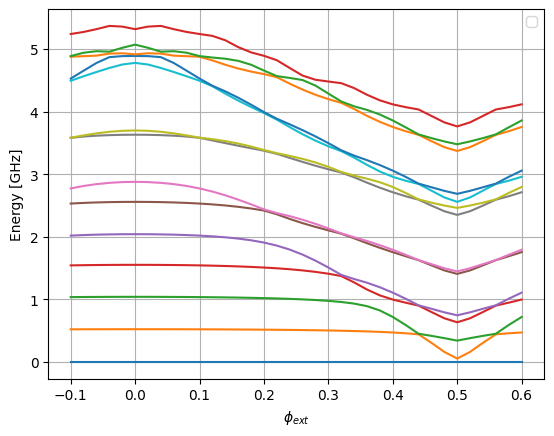

0.5 0.05389931828232086
0.5 0.34045701613576007
0.5 0.2929608819871623
0.565685424949238


In [34]:

for i in range(14):
        plt.plot(phiext_tab/(2*np.pi), (levels[i,:]- levels[0,:])/np.sqrt(16*EL*EC_shunt)**0)

plt.xlabel('$\phi_{ext}$')
plt.ylabel('Energy [GHz]')
plt.grid()
plt.legend()

plt.show()
print(phiext_tab[30]/(2*np.pi),levels[1,30]- levels[0,30])
print(phiext_tab[30]/(2*np.pi),levels[2,30]- levels[0,30])
print(phiext_tab[30]/(2*np.pi),levels[3,30]- levels[2,30])
print(np.sqrt(16*EL*EC_shunt))

In [ ]:
nng = 31
ng_tab = np.linspace(0,1,nng)


dim = [20,100]
nfluxpoints = 150
phiext = np.pi

levels_BO = np.zeros((nng,n_cutoff))
for k,ng in enumerate(ng_tab):
    levels_BO[k], a, b = Born_Op_diag(EC,EJ,EL,y,dim,n_cutoff,nfluxpoints,phiext,ng)
    
for j in range(8):
    plt.plot(ng_tab,levels_BO[:,j]-0.5*(levels_BO[:,0]+levels_BO[:,1]))
plt.xlabel(r'$n_g$')
plt.ylabel('Energy levels (GHZ)')
#plt.title(rf' Charge dispersion for $EC_J$={EC}, $EJ$={EJ}, $EL$={EL}, $y$={y}') 
#plt.hlines(b-0.5*(levels[0,0]+levels[0,1]),-1,1,linestyles='dashed')